In [1]:
import pickle
import collections
from urllib.request import urlopen
from data_processing import *
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 500)
#%matplotlib inline

# Set the task and experiment type
task_name = 'maptask'
base_url = 'https://raw.github.com/NathanDuran/Maptask-Corpus/master/maptask_data/'
metadata = pickle.load(urlopen(base_url + 'metadata/metadata.pkl'))
text_data = [line.decode('utf-8').rstrip('\r\n') for line in urlopen(base_url + 'train_set.txt')]

# Vocabulary Size
The number of words to keep in the vocabulary during pre-processing. Increments of 500 in the range [500, 8000].

Get the vocabulary size corresponding to max validation and test accuracy per model.

In [2]:
# Name of the experiment parameter for comparison
exp_param = 'vocab_size'

# Load vocabulary experiment data
vocab_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
vocab_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(vocab_mean_data.loc[[vocab_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
vocab_data_max = get_max(vocab_mean_data, [exp_param])
vocab_data_max

Best validation accuracy in mean data:
   model_name  vocab_size    val_acc  val_acc_std
41        gru        1200  58.872602     0.237911
Best test accuracy in mean data:
   model_name  vocab_size   test_acc  test_acc_std  f1_micro  f1_micro_std
43        gru         800  60.815372      0.828933  0.608617      0.007864


,model_name,vocab_size,val_acc,val_acc_std,vocab_size,test_acc,test_acc_std,f1_micro,f1_micro_std
0,cnn,600,57.700522,0.205082,1600,59.327587,0.673426,0.594098,0.006662
1,text cnn,200,56.597583,0.332002,1400,59.301722,0.500288,0.593121,0.005173
2,dcnn,600,56.076386,0.321341,600,59.194685,0.484078,0.592759,0.004803
3,rcnn,800,58.163241,0.242606,800,60.284482,0.437835,0.603186,0.004474
4,lstm,800,55.875112,0.381871,800,60.316810,0.468755,0.603910,0.004711
5,gru,1200,58.872602,0.237911,800,60.815372,0.828933,0.608617,0.007864


Plot accuracy of each model per vocabulary size.

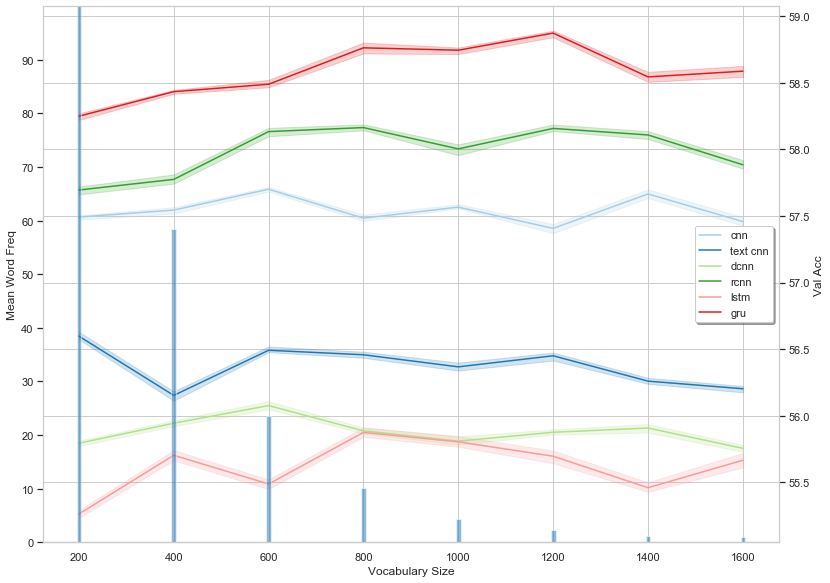

In [3]:
# TODO remove test data
# Get test and validation accuracy for each model
# vocab_acc_data = vocab_data.drop(vocab_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
# vocab_acc_data = vocab_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
# vocab_acc_data = vocab_acc_data.melt(id_vars=['model_name', exp_param])

# g, fig = plot_relplot(vocab_acc_data, x=exp_param, y='value', hue='model_name', col='variable', kind='line', ci='sd',
#                       title='', y_label='Accuracy', x_label='Vocabulary Size',  share_x=False, share_y=False, num_col=1,
#                       legend_loc='lower right', num_legend_col=4, colour='Paired')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

# Get word frequencies from metadata and bin into same values as experiment
word_freq = metadata['word_freq'].iloc[:1600]
ind_start, ind_end = 0, 200
freq_dict = dict()
for i in range(8):
    freq_dict[ind_end] = word_freq.loc[ind_start:ind_end].mean() # Binning
    # freq_dict[ind_end] = word_freq.loc[0:ind_end].sum() # Cumulative summing
    ind_start += 200
    ind_end += 200
word_freq = pd.DataFrame.from_dict(freq_dict, orient='index')
word_freq.reset_index(level=0, inplace=True)
word_freq.rename(columns={'index': 'vocab_size'}, inplace=True)

# Get experiment validation accuracy data for each model
vocab_acc_data = vocab_data.drop(vocab_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
vocab_acc_data = vocab_acc_data.rename(columns={'val_acc': 'Val Acc'})
vocab_acc_data = vocab_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(vocab_acc_data, word_freq, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Val Acc', x_label='Vocabulary Size', colour='Paired',
                          bar_x=exp_param, bar_y='Count', bar_axis_step=10, bar_axis_range=[0, 100], bar_width=10,
                          bar_y_label='Mean Word Freq', bar_alpha=0.5, bar_color='tab:blue', legend_loc='best', num_legend_col=1)
# fig.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA for each model, comparing different vocabulary size groups.

In [4]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(vocab_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(vocab_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(vocab_data, exp_param, metric)

All models vocab_size are normally distributed.
All models vocab_size have equal variance.
The following models do not have significant p-values when comparing vocab_size groups.
        sum_sq   df   mean_sq         F    PR(>F)    eta_sq  omega_sq
cnn   0.723056  7.0  0.103294  1.392605  0.221727  0.119247  0.033212
dcnn  0.713933  7.0  0.101990  1.403204  0.217392  0.120046  0.034078


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
cnn,0.723056,7.0,0.103294,1.392605,0.221727,0.119247,0.033212
text cnn,1.679138,7.0,0.239877,2.805677,0.012192,0.214315,0.136440
dcnn,0.713933,7.0,0.101990,1.403204,0.217392,0.120046,0.034078
rcnn,2.374514,7.0,0.339216,3.132326,0.006056,0.233441,0.157241
lstm,2.847214,7.0,0.406745,2.437593,0.026717,0.191585,0.111734
gru,2.866167,7.0,0.409452,4.014275,0.000924,0.280719,0.208704


Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

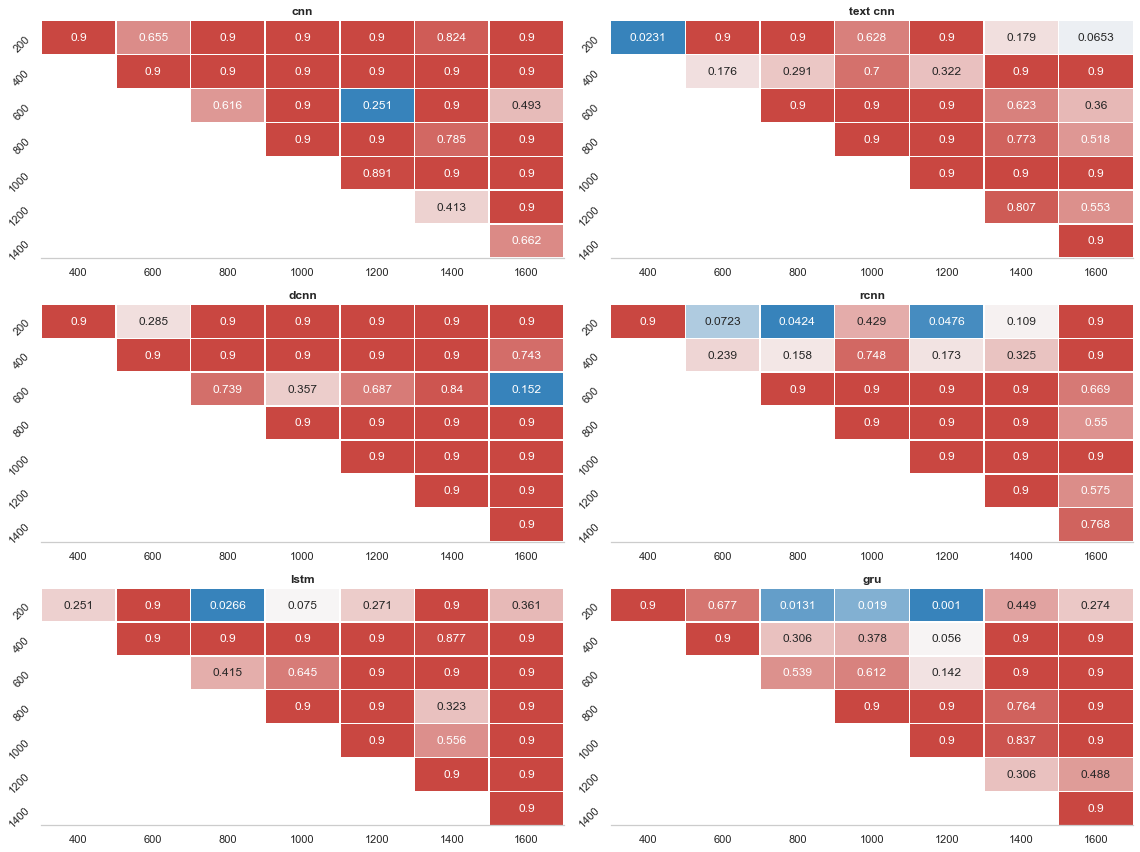

In [5]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(vocab_data, exp_param, metric, show_result=False)

# Remove vocab_size > 5000 to make plots nicer
# tukey_frame.drop(tukey_frame[(tukey_frame.group1 > 5000) | (tukey_frame.group2 > 5000)].index, inplace=True)
# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))

# Sequence Length
The number of tokens in the input sequence. Sentences are padded or truncated to this length.
Increments of 5 in the range [5, 50].

Get the sequence length corresponding to max validation and test accuracy per model.

In [6]:
# Name of the experiment parameter for comparison
exp_param = 'max_seq_length'

# Load sequence length experiment data
seq_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
seq_mean_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['val_acc'].idxmax()], ['model_name', exp_param, 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(seq_mean_data.loc[[seq_mean_data['test_acc'].idxmax()], ['model_name', exp_param, 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
seq_data_max = get_max(seq_mean_data, [exp_param])
seq_data_max

Best validation accuracy in mean data:
   model_name  max_seq_length    val_acc  val_acc_std
59        gru              30  58.677818     0.254389
Best test accuracy in mean data:
   model_name  max_seq_length   test_acc  test_acc_std  f1_micro  f1_micro_std
60        gru              25  60.872844      0.415885  0.608798      0.004192


,model_name,max_seq_length,val_acc,val_acc_std,max_seq_length,test_acc,test_acc_std,f1_micro,f1_micro_std
0,cnn,25,57.491556,0.263350,35,59.484913,0.514620,0.595366,0.005433
1,text cnn,40,56.401361,0.331929,55,59.283763,0.314875,0.592940,0.003252
2,dcnn,25,56.141233,0.243263,20,59.277298,0.442291,0.593193,0.004385
3,rcnn,25,58.132309,0.263509,25,60.214799,0.642516,0.602643,0.006468
4,lstm,10,57.976544,0.257621,50,60.178161,0.658406,0.602353,0.006754
5,gru,30,58.677818,0.254389,25,60.872844,0.415885,0.608798,0.004192


Plot accuracy of each model per sequence length.

In [ ]:
# TODO remove test data
# Get test and validation accuracy for each model
# seq_acc_data = seq_data.drop(seq_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
# seq_acc_data = seq_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
# seq_acc_data = seq_acc_data.melt(id_vars=['model_name', exp_param])
#
# g, fig = plot_relplot(seq_acc_data, x=exp_param, y='value', hue='model_name', col='variable', kind='line', ci=16,
#                       title='', y_label='Accuracy', x_label='Sequence Length',  share_x=False, share_y=False, num_col=1,
#                       legend_loc='lower right', num_legend_col=4, colour='Paired')
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_accuracy.png'))

# Get text data from training set and count sequence lengths
sentences = [line.split('|')[1] for line in text_data]
sent_lengths = [len(sent.split(' ')) for sent in sentences]
sent_lengths = collections.Counter(sent_lengths)
sent_lengths = pd.DataFrame.from_dict(dict(sorted(sent_lengths.items())), orient='index')

# Bin into same values as experiment
ind_start, ind_end = 0, 5
freq_dict = dict()
for i in range(10):
    # freq_dict[ind_end] = sent_lengths.loc[ind_start:ind_end].sum()
    freq_dict[ind_end] = sent_lengths.loc[0:ind_end].sum() # Cumulative sum
    ind_start += 5
    ind_end += 5
sent_lengths = pd.DataFrame.from_dict(freq_dict, orient='index')
sent_lengths.reset_index(level=0, inplace=True)
sent_lengths.rename(columns={'index': 'max_seq_length', 0: 'Count'}, inplace=True)
print(sent_lengths)

# Get experiment validation accuracy data for each model
seq_acc_data = seq_data.drop(seq_data.columns.difference(['model_name', exp_param, 'val_acc']), axis=1)
seq_acc_data = seq_acc_data.rename(columns={'val_acc': 'Val Acc'})
seq_acc_data = seq_acc_data.melt(id_vars=['model_name', exp_param])

# Plot line/bar chart
fig = plot_line_bar_chart(seq_acc_data, sent_lengths, x=exp_param, y='value', hue='model_name',
                          title='', y_label='Val Acc', x_label='Max Sequence Length', colour='Paired',
                          bar_x=exp_param, bar_y='Count', bar_axis_step=1000, bar_axis_range=None, bar_width=0.8,
                          bar_y_label='Num Sentences', bar_alpha=0.5, bar_color='tab:blue', legend_loc='lower right', num_legend_col=1)
# fig.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))

   max_seq_length  Count
0               5  13318
1              10  17550
2              15  19494
3              20  20324
4              25  20712
5              30  20881
6              35  20971
7              40  21010
8              45  21028
9              50  21041


Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA for each model, comparing different sequence length groups.

In [ ]:
# Set the metric to test
metric = 'val_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(seq_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(seq_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(seq_data, exp_param, metric)

Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

In [ ]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(seq_data, exp_param, metric, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param ,exp_param + '_anova.png'))

# Input Sequence Combinations

Compare vocabulary size (400, 800 or 1.7k words) and sequence lengths (25, 50 or 115 tokens).

In [ ]:
# Name of the experiment parameters for comparison
exp_params = ['vocab_size', 'max_seq_length']
# Load experiment data
inseq_data = load_dataframe(os.path.join(task_name, 'input_seq', 'input_seq_data.csv'))
inseq_mean_data = load_dataframe(os.path.join(task_name, 'input_seq', 'input_seq_mean_data.csv'))
inseq_mean_data.drop(inseq_mean_data[inseq_mean_data.vocab_size == 600].index, inplace=True)
inseq_data.drop(inseq_data[inseq_data.vocab_size == 600].index, inplace=True)
# Get the max values for each model
print("Best validation accuracy in mean data:")
print(inseq_mean_data.loc[[inseq_mean_data['val_acc'].idxmax()], ['model_name'] + exp_params + ['val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(inseq_mean_data.loc[[inseq_mean_data['test_acc'].idxmax()], ['model_name'] + exp_params + ['test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
inseq_data_max = get_max(inseq_mean_data, exp_params)
inseq_data_max

Test assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform ANOVA comparing vocabulary size (400, 800 or 1.7k words) and sequence lengths (25, 50 or 115 tokens) for each model.

In [ ]:
# Add column to identify each combination
inseq_data = inseq_data.drop(inseq_data.columns.difference(['model_name', 'val_acc', 'vocab_size', 'max_seq_length']), axis=1)
conditions = [(inseq_data['vocab_size'] == 400) & (inseq_data['max_seq_length'] == 25),
              (inseq_data['vocab_size'] == 800) & (inseq_data['max_seq_length'] == 50),
              (inseq_data['vocab_size'] == 1700) & (inseq_data['max_seq_length'] == 115)]
choices = ['V=400_S=25', 'V=800_S=50', 'V=1.7k_S=115']#'V=800_S=50',
inseq_data['exp_params'] = np.select(conditions, choices)
inseq_data.drop(inseq_data[inseq_data.exp_params == '0'].index, inplace=True)

# Set the metric to test and new exp_param column
metric = 'val_acc'
exp_param = 'exp_params'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(inseq_data, exp_param, metric)

# Run Levene test for equal variance
levene_test(inseq_data, exp_param, metric)

# Run ANOVA
one_way_anova_test(inseq_data, exp_param, metric)

# Run t-test
# t_test(inseq_data, exp_param, metric)

Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

In [ ]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(inseq_data, exp_param, metric, show_result=False)

# Generate heatmaps
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=45, height=4)
# g.savefig(os.path.join(task_name, exp_param , exp_param + '_anova.png'))

# Word Vectors

Compare different dimensions of Word2Vec, GloVe, Fasttext, Numberbatch and Dependency for each model.
Dimension increments of 50 in range [100, 300].

In [ ]:
# Name of the experiment parameter for comparison
exp_params = ['embedding_type', 'embedding_dim']

# Load language models experiment data
embed_data = load_dataframe(os.path.join(task_name, 'embedding_type', 'embedding_type_data.csv'))
embed_mean_data = load_dataframe(os.path.join(task_name,  'embedding_type', 'embedding_type_mean_data.csv'))

# Remove random embeddings because they are strictly worse
embed_data = embed_data.drop(embed_data[embed_data['embedding_type'] == 'random'].index)
embed_mean_data = embed_mean_data.drop(embed_mean_data[embed_mean_data['embedding_type'] == 'random'].index)

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(embed_mean_data.loc[[embed_mean_data['val_acc'].idxmax()], ['model_name'] + exp_params + ['val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(embed_mean_data.loc[[embed_mean_data['test_acc'].idxmax()], ['model_name'] + exp_params + ['test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
embed_data_max = get_max(embed_mean_data, exp_params)
embed_data_max

Plot accuracy of each model per embedding type and dimension.

In [ ]:
# Get test and validation accuracy for each model
embed_acc_data = embed_mean_data.drop(embed_mean_data.columns.difference(['model_name'] + exp_params + ['val_acc', 'test_acc']), axis=1)

g, fig = plot_facetgrid(embed_acc_data, x='embedding_type', y='embedding_dim', hue='val_acc', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=2, colour='YlGnBu', num_colour=20,
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, height=4)
# g.savefig(os.path.join(task_name, 'embedding_type', 'embedding_type_accuracy.png'))

Test ANOVA assumptions using Shapiro-Wilks test for normality and Levene test for equal variance (Homoscedasticity).

Perform Two-way ANOVA for each model, comparing different embedding type and dimension groups.

In [ ]:
# Set the metric to test
metric = 'val_acc'

# Add embedding type and dimension column
embed_data['embedding_params'] = embed_data.apply(lambda row: row['embedding_type'] + "_" + str(row['embedding_dim']), axis=1)

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(embed_data, 'embedding_params', metric)

# Run Levene test for equal variance
levene_test(embed_data, 'embedding_params', metric)

# Run Two-way ANOVA
two_way_anova_test(embed_data, 'embedding_dim', 'embedding_type', metric, show_result=True)

Tukey Honest Significant Difference Post-Hoc analysis for pairwise comparison of groups.

Heatmaps shows Tukey-HSD results for each model.

In [ ]:
# Run Tukey-HSD post-hoc analysis
tukey_frame = tukey_hsd(embed_data, 'embedding_params', metric, show_result=False)

# Just get the models where there is a significant difference
tukey_frame = tukey_frame.loc[(tukey_frame['model_name'] == 'dcnn') | (tukey_frame['model_name'] == 'lstm')]

# Generate heatmap
g, fig = plot_facetgrid(tukey_frame, x='group1', y='group2', hue='p-value', col='model_name', kind='heatmap',
                        title='', y_label='', x_label='', num_col=1, colour='RdBu_r',
                        annot=True, fmt='0.3', linewidths=0.5, cbar=False, custom_boundaries=[0.0, 0.05, 1.0],
                        y_tick_rotation=0, x_tick_rotation=45)
# g.savefig(os.path.join(task_name, 'embedding_type' ,'embedding_type_anova.png'))

# Input sequence and embeddings final results

Results for the 6 base models using the parameters (vocabulary size, sequence length and embeddings) from previous experiments.

In [ ]:
# Name of the experiment parameter for comparison
exp_param = 'input_seq_final'

# Load language models experiment data
inseq_final_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
inseq_final_mean_data = load_dataframe(os.path.join(task_name,  exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(inseq_final_mean_data.loc[[inseq_final_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(inseq_final_mean_data.loc[[inseq_final_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
inseq_final_data_max = get_max(inseq_final_mean_data, [])
inseq_final_data_max

# Model variants results

Results and comparison for the bi-directional, multi-layer and CRF for recurrent models.
Results and comparison for the attentional variants of all 6 base models.

In [ ]:
# Name of the experiment parameter for comparison
exp_param = 'model_variants'

# Load language models experiment data
variants_data = load_dataframe(os.path.join(task_name, exp_param, exp_param + '_data.csv'))
variants_mean_data = load_dataframe(os.path.join(task_name,  exp_param, exp_param + '_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(variants_mean_data.loc[[variants_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(variants_mean_data.loc[[variants_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
variants_data_max = get_max(variants_mean_data, [])
variants_data_max

Merge base and variant results then test assumptions using Shapiro-Wilks test for normality
and Levene test for equal variance (Homoscedasticity).

In [ ]:
# Merge all of the supervised models results
final_data = pd.concat([inseq_final_data, variants_data], ignore_index=True)
final_data.drop('index', axis=1, inplace=True)

metric = 'test_acc'

# Run Shaprio-wilks test for normal distribution
shapiro_wilk_test(final_data, 'model_name', metric)

# Run Levene test for equal variance
levene_test(final_data, 'model_name', metric)

Run ANOVA between recurrent models and their bi-directional, multi layer and CRF variants.

In [ ]:
# Get only the recurrent models and variants
lstm_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|gru')]
gru_data = final_data[~final_data.model_name.str.contains('attn|cnn|rcnn|dcnn|lstm')]

print("LSTM Variants")
# Run ANOVA
one_way_anova_test(lstm_data, 'model_name', metric)

# Run Tukey-HSD post-hoc analysis
tukey_hsd(lstm_data, 'model_name', metric)

print("GRU Variants")
# Run ANOVA
one_way_anova_test(gru_data, 'model_name', metric)

# Run Tukey-HSD post-hoc analysis
tukey_hsd(gru_data, 'model_name', metric)

Run t-test comparing base models and their attentional variants.

In [ ]:
# Get only base and attentional models
attn_data = final_data[~final_data.model_name.str.contains('bi|deep|crf')]

# Create results frame
t_test_frame = pd.DataFrame(columns=['model_name', 't-stat', 'p-value'])

# Perform t-test for each model and its attn variant
for model in ['cnn', 'text cnn', 'dcnn', 'rcnn', 'lstm', 'gru']:

    # Select the data to compare
    data_a = attn_data.loc[(attn_data['model_name'] == model)][metric]
    data_b = attn_data.loc[(attn_data['model_name'] == model + ' attn')][metric]

    # T-test
    t, p = ttest_ind(data_a, data_b)

    # Append to result frame
    t_test_frame = t_test_frame.append({'model_name': model, 't-stat': t, 'p-value': p}, ignore_index=True)


if all(p_value <= 0.05 for p_value in t_test_frame['p-value']):
    print("All models have significant p-values when comparing " + exp_param + " groups.")
else:
    print("The following models do not have significant p-values when comparing " + exp_param + " groups.")
    print(t_test_frame.loc[t_test_frame['p-value'] > 0.05])

# Language Models

Using pre-trained language models to generate sequence representations.

In [ ]:
# Name of the experiment parameter for comparison
exp_param = 'embedding_type'

# Load language models experiment data
lm_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models_data.csv'))
lm_mean_data = load_dataframe(os.path.join(task_name, 'language_models', 'language_models_mean_data.csv'))

# Get the max values for each model
print("Best validation accuracy in mean data:")
print(lm_mean_data.loc[[lm_mean_data['val_acc'].idxmax()], ['model_name', 'val_acc', 'val_acc_std']])
print("Best test accuracy in mean data:")
print(lm_mean_data.loc[[lm_mean_data['test_acc'].idxmax()], ['model_name', 'test_acc', 'test_acc_std', 'f1_micro', 'f1_micro_std']])
lm_data_max = get_max(lm_mean_data, [exp_param])
lm_data_max.drop('embedding_type', axis=1, inplace=True)
lm_data_max

Plot accuracy of each language model.

In [ ]:
# TODO remove test data
# Get test and validation accuracy for each model
lm_acc_data = lm_data.drop(lm_data.columns.difference(['model_name', exp_param, 'val_acc', 'test_acc']), axis=1)
lm_acc_data = lm_acc_data.rename(columns={'val_acc': 'Val Acc', 'test_acc': 'Test Acc'})
lm_acc_data = lm_acc_data.melt(id_vars=['model_name', exp_param])

g, fig = plot_facetgrid(lm_acc_data, x="model_name", y="value", hue="model_name", col='variable', kind='swarm_violin',
                        num_legend_col=2, y_label='Accuracy', x_label='Language Model',
                        share_y=False, num_col=1, colour='Paired', dodge=False)
# g.savefig(os.path.join(task_name, exp_param, exp_param + '_accuracy.png'))
